# Классификация текста по "настроению" с помощью NLP
Описание задачи: 

Используя датасет отзывов к фильмам, тексту и картинкам (постам) (а также используя бальную систему оценок), определить веса позитивного и негативного влияния слов/фраз, считая, что определение каких-то оценок нейросетью является стандартом настроения человека, который писал этот отзыв или ставил оценку.

На основе датасетов комментариев к вышеперечисленным объектам, определить корреляцию положительного или отрицательного влияния картинки на настроение человека (считать, что настроение определяется положительностью или отрицательностью текста в комментариях).

Вход: датасет оценок к различным объектам (то есть оценка по какой-то шкале этих объектов разными людьми) и комментариев к этим объектам.

Выход: определение текста как положительного или отрицательного по настроению (на основании его оценки и/или отзыва об этом объекте) человека.

**Цель исследования.** Разработать модель анализа текстов (отзывов, комментариев) с целью определения эмоциональной окраски высказывания - положительной или отрицательной. Такая задача известна как *анализ тональности* (sentiment analysis).

**Математическая постановка.** Пусть $T=\{t_1,t_2,\dots,t_n\}$ — множество текстов, а метки $y_i\in\{0,1\}$ определяют тональность (0 — негативный, 1 — позитивный). Требуется построить отображение
$$
f: T\to\{0,1\},
$$
такое, что $f(t_i)\approx y_i$.

Будем использовать популярный алгоритм "Наивный Байес", широко используемый для классификации текста. Наряду с мощной библиотекой [NLTK](https://www.nltk.org/install.html) мы используем стандартные процедуры для классификации тональности помеченного текста.

Для начала подключим основные библиотеки и скачаем основные грамматические пакеты для токенизации слов датасетов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk


from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Загрузка необходимых корпусов NLTK
nltk.download('popular')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Error loading popular: HTTP Error 404: Not Found
[nltk_data] Error loading wordnet: HTTP Error 404: Not Found
[nltk_data] Error loading stopwords: HTTP Error 404: Not Found


False

## Twitter sentiment analysis
### About Dataset
Context

Determine emotional coloring of twits.

Content

train.csv - the training set

Data fields

ItemID - id of twit

Sentiment - sentiment

SentimentText - text of the twit

0 - negative

1 - positive

Используются размеченные корпуса твитов и отзывов на фильмы. Файлы приводятся к единому формату с колонками `['ID','Sentiment','Text']`. Метка $\text{Sentiment}\in\{0,1\}$.

In [2]:
train = pd.read_csv('./datasets/train.csv', encoding='iso-8859-1', names=['ID','Sentiment','Text'])
train.head(3)

,ID,Sentiment,Text
0,ItemID,Sentiment,SentimentText
1,1,0,is so sad for my APL frie...
2,2,0,I missed the New Moon trail...


In [3]:
train.head(20)

,ID,Sentiment,Text
0,ItemID,Sentiment,SentimentText
1,1,0,is so sad for my APL frie...
2,2,0,I missed the New Moon trail...
3,3,1,omg its already 7:30 :O
4,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
5,5,0,i think mi bf is cheating on me!!! ...
6,6,0,or i just worry too much?
7,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
8,8,0,Sunny Again Work Tomorrow :-| ...
9,9,1,handed in my uniform today . i miss you ...


In [4]:
train.shape

(99990, 3)

## Sentiment140 dataset with 1.6 million tweets

### About dataset (from source)

This is the sentiment140 dataset.

It contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment.

It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet (2087)
3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted (robotickilldozr)
6. text: the text of the tweet (Lyx is cool)

The official link regarding the dataset with resources about how it was generated is here

The official paper detailing the approach is here

According to the creators of the dataset:

"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search"

citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [5]:
tmp = pd.read_csv('./datasets/training.noemoticon.csv', encoding='iso-8859-1',
                 names=["Sentiment", "ID", "Date", "Flag", "User", "Text"])

In [6]:
tmp.loc[:, "Sentiment"].unique()

array([0, 4])

In [7]:
tmp.shape

(1600000, 6)

In [8]:
tmp["Sentiment"] /= 4

In [9]:
tmp.loc[:, "Sentiment"].unique()

array([0., 1.])

In [10]:
tmp[tmp.Flag == "NO_QUERY"]

,Sentiment,ID,Date,Flag,User,Text
0,0.0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0.0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0.0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0.0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0.0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1.0,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1.0,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1.0,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1.0,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [11]:
train = pd.concat(
    [
        train.loc[:, ["Sentiment", "Text"]],
        tmp.loc[:, ["Sentiment", "Text"]]
    ],
    axis=0)
train.shape

(1699990, 2)

## IMDB dataset

### About dataset (from source)

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.

It contains review and sentement

In [12]:
tmp = pd.read_csv('./datasets/imdb_dataset.csv', encoding='iso-8859-1',
                 names=["Text", "Sentiment"])

In [13]:
tmp.head()

,Text,Sentiment
0,review,sentiment
1,One of the other reviewers has mentioned that ...,positive
2,A wonderful little production. <br /><br />The...,positive
3,I thought this was a wonderful way to spend ti...,positive
4,Basically there's a family where a little boy ...,negative


In [14]:
tmp["Sentiment"] = tmp["Sentiment"].map(lambda x: 1 if x == "positive" else 0)
tmp.head()

,Text,Sentiment
0,review,0
1,One of the other reviewers has mentioned that ...,1
2,A wonderful little production. <br /><br />The...,1
3,I thought this was a wonderful way to spend ti...,1
4,Basically there's a family where a little boy ...,0


In [15]:
train = pd.concat(
    [
        train.loc[:, ["Sentiment", "Text"]],
        tmp.loc[:, ["Sentiment", "Text"]]
    ],
    axis=0)
train.shape

(1749991, 2)

In [16]:
train.head()

,Sentiment,Text
0,Sentiment,SentimentText
1,0,is so sad for my APL frie...
2,0,I missed the New Moon trail...
3,1,omg its already 7:30 :O
4,0,.. Omgaga. Im sooo im gunna CRy. I'...


Теперь проверим, что составленный датасет принимает только допустимые нормализованные значения. Для этого проверим набор значений, который храниться в колонке настроения.

In [17]:
train['Sentiment'].unique()

array(['Sentiment', '0', '1', 0.0, 1.0], dtype=object)

Заметим, что информация некорректная. Нормализованное значение настроения должно быть от 0 до 1, но присутствуют значения строк и чисел как строк. Для этого посмотрим, какое количество строк принимает неправильные значения, наиболее сильно нас интересует количество строк со значением текста "Sentiment" вместо чисел.

In [18]:
train['Sentiment'].value_counts()

Sentiment
0.0          825001
1.0          825000
1             56457
0             43532
Sentiment         1
Name: count, dtype: int64

Заметим, что только одна строка принимает неверное значение, отсортируем её и приведём значения к корректному типу значений с плавающей запятой.

In [19]:
train.dtypes

convert_dict = {'Sentiment': np.float32}

train = train.loc[train['Sentiment'] != "Sentiment"]
train = train.astype(convert_dict)
train["Sentiment"].unique()

array([0., 1.], dtype=float32)

Как мы могли заметить ранее в тексте, который получили с IMDB, присутствуют HTML теги, отфильтруем их, чтобы оставить только действительные слова текста.
То есть мы очищаем текст от HTML-тегов и нестандартных символов. Удаляем дубликаты и слишком короткие записи. Пусть $x$ — исходная строка, тогда очищенная версия $x'$ получается применением регулярного выражения и нормализации регистра.


In [20]:
import re

# HTML tag extractor regexp
p = re.compile(r'<.*>')

train["Text"] = train["Text"].map(lambda d: p.sub('', d))

train.head()


,Sentiment,Text
1,0.0,is so sad for my APL frie...
2,0.0,I missed the New Moon trail...
3,1.0,omg its already 7:30 :O
4,0.0,.. Omgaga. Im sooo im gunna CRy. I'...
5,0.0,i think mi bf is cheating on me!!! ...


## Анализ входных данных

In [21]:
lens = train.Text.str.len()
lens.mean(), lens.std(), lens.max()

(np.float64(93.6623620706404), np.float64(147.4998303794467), np.int64(5911))

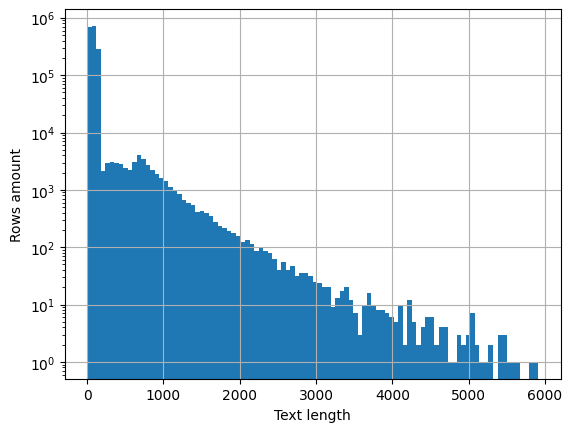

In [22]:
lens.hist(log=True, bins=100)
plt.xlabel('Text length')
plt.ylabel('Rows amount')
plt.show()

In [23]:
train['Sentiment'].value_counts()

Sentiment
1.0    881457
0.0    868533
Name: count, dtype: int64

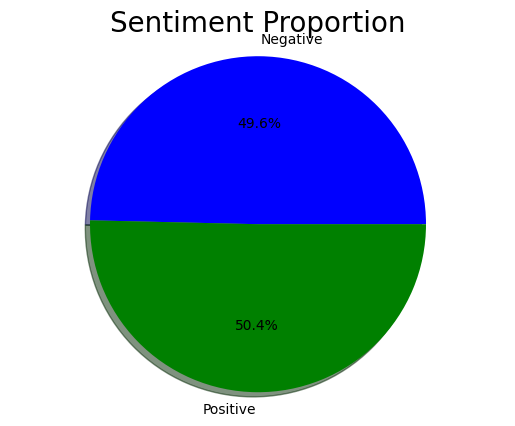

In [24]:
labels = ['Negative', 'Positive']
sizes = [train['Sentiment'].value_counts()[0],
         train['Sentiment'].value_counts()[1]
        ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, colors=['blue', 'green'])
ax1.axis('equal')
plt.title('Sentiment Proportion', fontsize=20)
plt.show()

Нам повезло с набором датасетов, т.к. сильных перекосов в какую-либо сторону из доступных вариантов ответа не выявлено, значит, вероятность того, что сеть не будет переобучена на одном из кейсов на этапе входных данных, отсутствует. Так, мы будем использовать датасеты в их исходном варианте без дополнительного перераспределения и разбиения выборки.

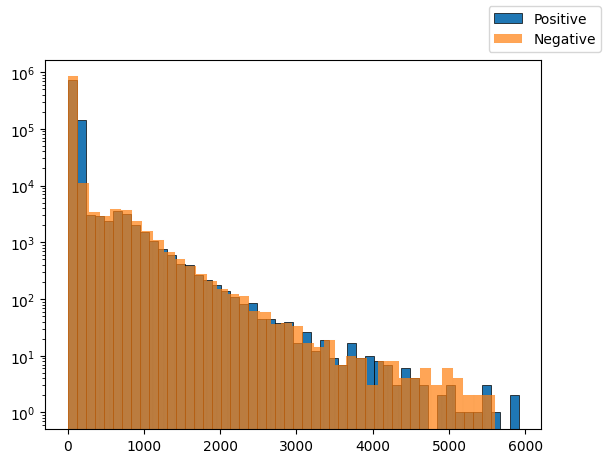

In [25]:
len_to_sentiment = train.copy()
len_to_sentiment.Text = len_to_sentiment.Text.str.len()
len_to_positive = len_to_sentiment.loc[len_to_sentiment.Sentiment == 1.0]
len_to_negative = len_to_sentiment.loc[len_to_sentiment.Sentiment == 0.0]

fig1, ax1 = plt.subplots()

ax1.hist(len_to_positive.Text, log=True, label="Positive", bins=50, edgecolor='black', linewidth=0.5)
ax1.hist(len_to_negative.Text, log=True, label="Negative", bins=40, edgecolor='black', linewidth=0.01, alpha=0.7)
fig1.legend()
plt.show()


Отметим, что данные датасета распределены предположительно по нормальному распределению в соотнесении количества строк
и возможного негативного или позитивного характера тектста, что сообщает о хорошо подготовленном датасете для обучения.

# Tokenization


Цель токенизации — разбить предложение или абзац на конкретные токены или слова. По сути мы хотим преобразовать человеческий язык в более абстрактное представление, с которым смогут работать компьютеры - разбиваем строки $s$ на последовательность токенов $w_1,\dots,w_m$.

Зададим возможное множество, определяющее всё, что не может являться словом, и составим на его основе токенизатор, который будем использовать в дальнейшем.

In [26]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨ «»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

## StopWords

Теперь отсортируем стоп-слова, т.е. те слова, которые не несут особого вклада в определение "настроения" текста (к примеру, союзы). Так мы получим более "значимый" для нейронной сети текст, что позволит увеличить продуктивность обучения. NLTK библиотека предоставляет свой корпус заранее подготовленных стоп слов для английской речи, ими и воспользуемся для фильтрации.

Т.о. мы исключаем список частых слов $\mathcal S$ (например, артикли/союзы), чтобы уменьшить шум признаков.

In [27]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

words = stopwords.words('english')
print(len(words), "\n", words)

198 
 ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't"

In [28]:
#nltk.download("stopwords") 

train.Text = [" ".join([w for w in tokenize(l) if w.lower() not in stopwords.words('english')]) for l in train.Text]

In [29]:
train.head()
print(train.Text)

1                 sad APL friend . . . . . . . . . . . . .
2                            missed New Moon trailer . . .
3                                     omg already 7 : 30 :
4        . . Omgaga . Im sooo im gunna CRy . ' dentist ...
5                             think mi bf cheating ! ! ! _
                               ...                        
49996    thought movie right good job . ' creative orig...
49997    Bad plot , bad dialogue , bad acting , idiotic...
49998    Catholic taught parochial elementary schools n...
49999    ' going disagree previous comment side Maltin ...
50000    one expects Star Trek movies high art , fans e...
Name: Text, Length: 1749990, dtype: object


# Stemmer

Выделим корни слов, т.к. они несут основную логику. Так мы нормализуем значения по лингвистическому признаку, что позволит нам увеличить концентрацию корреляции нейронной сети со смысловой частью слов.

Формально:

Отображение $\operatorname{stem}: w\mapsto w^{\ast}$, где $w^{\ast}$ — основа слова (например, *playing*, *played*, *plays* $\mapsto$ *play*). Это уменьшает размер словаря, сохраняя смысловое ядро.

Для примера посмотрим, как работает алгоритм NLTK на однокорреных английских словах

In [30]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
 
words = ["game","gaming","gamed","games"]
stemmer = PorterStemmer()
 
for word in words:
    print(stemmer.stem(word))

game
game
game
game


In [31]:
ps = nltk.PorterStemmer()
train.Text = [" ".join([ps.stem(w) for w in tokenize(l)]) for l in train.Text]
#train.Text = [ps.stem(l) for l in train.Text]
train.Text.head()

1             sad apl friend . . . . . . . . . . . . .
2                          miss new moon trailer . . .
3                                 omg alreadi 7 : 30 :
4    . . omgaga . im sooo im gunna cri . ' dentist ...
5                            think mi bf cheat ! ! ! _
Name: Text, dtype: object

# Разбиение датасета на обучающий и тренировочный

Разделяем корпус на обучающую и тестовую части. Пусть $\mathcal D=\{(x_i,y_i)\}$ — корпус после предобработки. Используем разбиение $80/20$ с фиксированным сидом для воспроизводимости.

In [32]:
X = train.Text
y = train.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [33]:
train1=pd.concat([X_train,y_train], axis=1)
train1.shape

(1399992, 2)

In [34]:
type(X_train)

pandas.core.series.Series

# ​Частота документа, обратная частоте термина Term Frequency-Inverse Document Frequency (TF-IDF)

Для уточнения результата, а именно наиболее релевантного реагирования на слова в сообщениях, будем использовать метод TF-IDF.

Term-frequency-inverse document frequency (TF-IDF) — это один из способов оценить тему статьи по содержащимся в ней словам. При использовании TF-IDF словам придается вес, TF-IDF измеряет релевантность, а не частоту. То есть количество слов заменяется оценками TF-IDF по всему набору данных.

TF-IDF измеряет количество раз, когда слова появляются в данном документе (это частота терминов). Но поскольку такие слова, как «и» или «the», часто встречаются во всех документах, их систематически игнорируют. Это часть частоты обратного документа. Чем в большем количестве документов встречается слово, тем менее ценным оно является как сигнал. Предполагается, что в качестве маркеров останутся только часто встречающиеся И отличительные слова. Релевантность каждого слова TF-IDF представляет собой нормализованный формат данных, сумма весов токенов равна единице.

Формально:
Пусть $n_{t,d}$ — число вхождений терма $t$ в документ $d$, $N$ — число документов, $n_t$ — число документов, содержащих $t$. Определим
$$
\operatorname{TF}(t,d) = \frac{n_{t,d}}{\sum_k n_{k,d}},\qquad
\operatorname{IDF}(t) = \log\frac{N}{n_t+1},\qquad
\operatorname{TFIDF}(t,d) = \operatorname{TF}(t,d)\cdot \operatorname{IDF}(t).
$$
Для повышения устойчивости используем логлинейный масштаб TF: $\operatorname{tf}'=1+\log(\operatorname{tf})$.

In [35]:
n = train1.shape[0]
vec = TfidfVectorizer(ngram_range=(1,5),
                      tokenizer=tokenize,
                      min_df=3,      # игнорировать термины, у которых df строго ниже порогового значения
                      max_df=0.9,    # игнорировать термины, у которых df строго превышает пороговое значение (стоп-слова, специфичные для корпуса)
                      strip_accents='unicode', # Удаление акцентов на этапе предварительной обработки
                      use_idf=True,
                      smooth_idf=True,  # Сглаживайте веса IDF, добавляя единицу к частоте документов,
                                     # как если бы был замечен дополнительный документ, содержащий каждый термин в
                                     # коллекции ровно один раз. Предотвращает нулевое деление.
                      sublinear_tf=True, # Применяем сублинейное масштабирование tf, т.е. заменяем tf на 1 + log(tf).
                      max_features=100000
                     )
trn_term_doc = vec.fit_transform(train1['Text'])
test_term_doc = vec.transform(X_test)

C:\Users\sonak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
X_test.shape

(349998,)

In [37]:
# Это создает разреженную матрицу только с небольшим количеством ненулевых элементов
# (сохраненных элементов в представлении ниже).
trn_term_doc, test_term_doc

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 28882369 stored elements and shape (1399992, 100000)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 7230717 stored elements and shape (349998, 100000)>)

Используем основное уравнение функции Байеса

Считаем вероятность выпадения слова в таблице x с колонкой y со значением y_i, суммируем всё по строчно.

In [38]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [39]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=3,solver='newton-cg')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [40]:
x = trn_term_doc
test_x = test_term_doc

label_cols=['Sentiment']
preds = np.zeros((len(X_test), len(label_cols)))

In [41]:
ps = nltk.PorterStemmer()
m,r = get_mdl(train1['Sentiment'])

In [42]:
preds[:,0] = m.predict_proba(test_x.multiply(r))[:,1]

Теперь, проверим на тестовой выборке корректность работы нейронной сети по предсказанию "настроения" текста.

In [43]:
y_pred=pd.DataFrame(preds.round(decimals=0), columns = label_cols)

In [44]:
accuracy_score(y_test, y_pred)

0.7936016777238727

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79    173910
         1.0       0.78      0.82      0.80    176088

    accuracy                           0.79    349998
   macro avg       0.79      0.79      0.79    349998
weighted avg       0.79      0.79      0.79    349998

[[133626  40284]
 [ 31955 144133]]


Здесь можно проверить свой текст на "настроение":

In [46]:
def text_processing(s):
    s = " ".join([w for w in tokenize(s) if w.lower() not in stopwords.words('english')])
    s = " ".join([ps.stem(w) for w in tokenize(s)])
    s = pd.Series([s])
    res = vec.transform(s)
    preds = np.zeros((len(s), 1))
    preds[:,0] = m.predict_proba(res.multiply(r))[:,1]
    return round(preds[0][0])

In [47]:
s = '''good film'''
"positive" if (text_processing(s)) else "negative"

'positive'

In [48]:
text_processing(s)

1

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import os
import random

RANDOM_STATE = 100
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [50]:
def print_report(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))

def plot_conf_mat(y_true, y_pred, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5,4))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(title)
    plt.show()

def plot_roc_pr(y_true, scores, title_suffix=""):
    # scores — вероятности класса 1 или decision_function
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    RocCurveDisplay.from_predictions(y_true, scores, ax=ax[0])
    ax[0].set_title(f"ROC{title_suffix}")
    PrecisionRecallDisplay.from_predictions(y_true, scores, ax=ax[1])
    ax[1].set_title(f"PR curve{title_suffix}")
    plt.show()


=== LinearSVC (calibrated) ===
Accuracy: 0.7903588020502974
              precision    recall  f1-score   support

         0.0     0.8000    0.7708    0.7851    173910
         1.0     0.7815    0.8097    0.7953    176088

    accuracy                         0.7904    349998
   macro avg     0.7908    0.7902    0.7902    349998
weighted avg     0.7907    0.7904    0.7903    349998



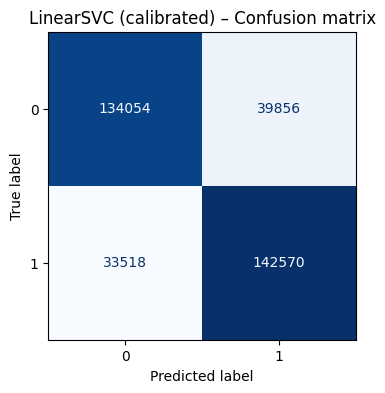

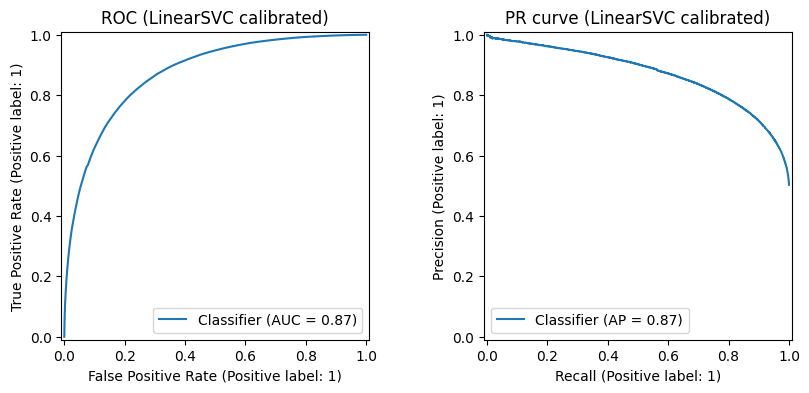

In [54]:
lsvc = LinearSVC(C=1.0, class_weight=None, random_state=RANDOM_STATE)
calibrated_lsvc = CalibratedClassifierCV(lsvc, method="sigmoid", cv=3)

calibrated_lsvc.fit(X_train_vec, y_train)
y_pred_lsvc = calibrated_lsvc.predict(X_test_vec)

print("=== LinearSVC (calibrated) ===")
print_report(y_test, y_pred_lsvc)
plot_conf_mat(y_test, y_pred_lsvc, "LinearSVC (calibrated) – Confusion matrix")

y_score_lsvc = calibrated_lsvc.predict_proba(X_test_vec)[:,1]
plot_roc_pr(y_test, y_score_lsvc, " (LinearSVC calibrated)")

C:\Users\sonak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


=== LinearSVC (calibrated) ===
Accuracy: 0.7903588020502974
              precision    recall  f1-score   support

         0.0     0.8000    0.7708    0.7851    173910
         1.0     0.7815    0.8097    0.7953    176088

    accuracy                         0.7904    349998
   macro avg     0.7908    0.7902    0.7902    349998
weighted avg     0.7907    0.7904    0.7903    349998



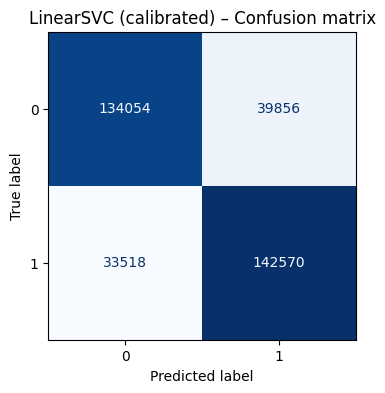

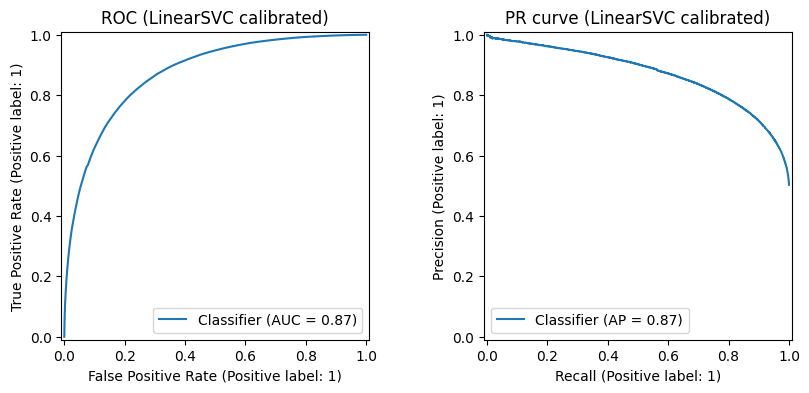

In [53]:
X_train_vec = vec.fit_transform(X_train)
X_test_vec  = vec.transform(X_test)

svc = LinearSVC(C=1.0, class_weight=None, random_state=RANDOM_STATE)
calibrated_lsvc = CalibratedClassifierCV(lsvc, method="sigmoid", cv=3)

calibrated_lsvc.fit(X_train_vec, y_train)
y_pred_lsvc = calibrated_lsvc.predict(X_test_vec)

print("=== LinearSVC (calibrated) ===")
print_report(y_test, y_pred_lsvc)
plot_conf_mat(y_test, y_pred_lsvc, "LinearSVC (calibrated) – Confusion matrix")


y_score_lsvc = calibrated_lsvc.predict_proba(X_test_vec)[:,1]
plot_roc_pr(y_test, y_score_lsvc, " (LinearSVC calibrated)")



=== Logistic Regression (baseline) ===
Accuracy: 0.7942502528585877
              precision    recall  f1-score   support

         0.0     0.8040    0.7748    0.7891    173910
         1.0     0.7853    0.8134    0.7991    176088

    accuracy                         0.7943    349998
   macro avg     0.7946    0.7941    0.7941    349998
weighted avg     0.7946    0.7943    0.7942    349998



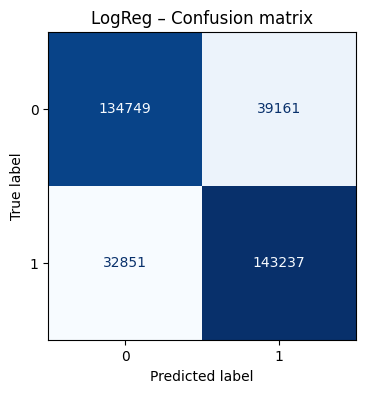

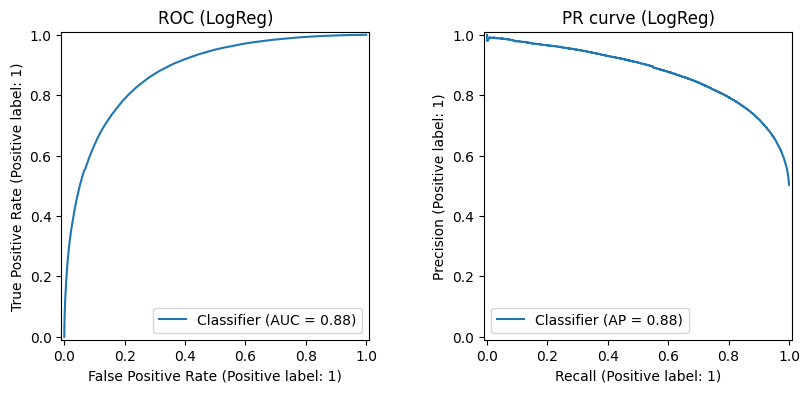

<Figure size 640x480 with 0 Axes>

In [55]:
logreg = LogisticRegression(
    solver="saga",          # подходит для разреженных TF-IDF и L2/L1
    penalty="l2",
    C=1.0,
    max_iter=1000,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

logreg.fit(X_train_vec, y_train)
y_pred_lr = logreg.predict(X_test_vec)

print("=== Logistic Regression (baseline) ===")
print_report(y_test, y_pred_lr)
plot_conf_mat(y_test, y_pred_lr, "LogReg – Confusion matrix")

# для ROC/PR нужны вероятности класса 1
y_score_lr = logreg.predict_proba(X_test_vec)[:,1]
plot_roc_pr(y_test, y_score_lr, " (LogReg)")
plt.savefig("LogReg_res.png", dpi=300, bbox_inches="tight")


=== MultinomialNB ===
Accuracy: 0.7672615272087269
              precision    recall  f1-score   support

         0.0     0.7624    0.7722    0.7673    173910
         1.0     0.7721    0.7624    0.7672    176088

    accuracy                         0.7673    349998
   macro avg     0.7673    0.7673    0.7673    349998
weighted avg     0.7673    0.7673    0.7673    349998



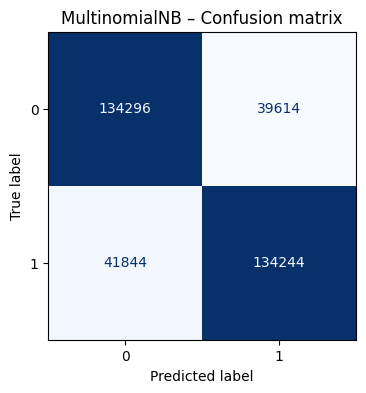

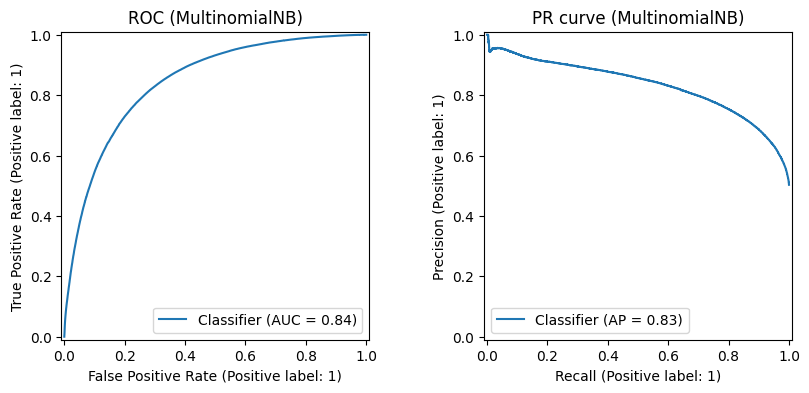

In [56]:
mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train_vec, y_train)
y_pred_nb = mnb.predict(X_test_vec)
print("=== MultinomialNB ===")
print_report(y_test, y_pred_nb)
plot_conf_mat(y_test, y_pred_nb, "MultinomialNB – Confusion matrix")

y_score_nb = mnb.predict_proba(X_test_vec)[:,1]
plot_roc_pr(y_test, y_score_nb, " (MultinomialNB)")


best_mnb = mnb

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best LogReg: {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
=== Logistic Regression (GridSearch) ===
Accuracy: 0.7942502528585877
              precision    recall  f1-score   support

         0.0     0.8040    0.7748    0.7891    173910
         1.0     0.7853    0.8134    0.7991    176088

    accuracy                         0.7943    349998
   macro avg     0.7946    0.7941    0.7941    349998
weighted avg     0.7946    0.7943    0.7942    349998



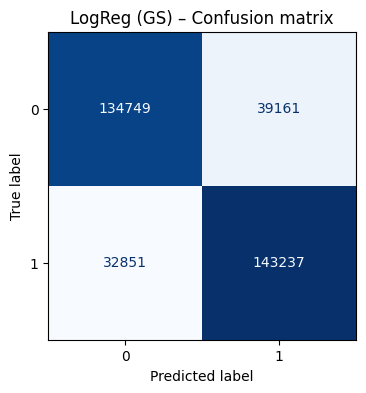

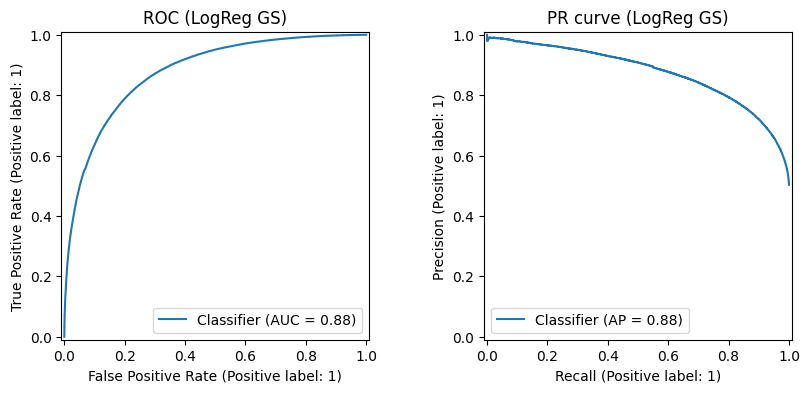

In [57]:
param_grid_lr = {
    "C": [0.25, 0.5, 1.0, 2.0],
    "penalty": ["l2"],               # "l1" тоже можно, но медленнее
    "solver": ["saga"],              # saga поддерживает l1/l2 и большие матрицы
    "class_weight": [None, "balanced"]
}
gs_lr = GridSearchCV(
    logreg, param_grid_lr, cv=3, n_jobs=-1, verbose=1,
    scoring="f1"
)
gs_lr.fit(X_train_vec, y_train)
best_lr = gs_lr.best_estimator_
print("Best LogReg:", gs_lr.best_params_)

y_pred_lr_gs = best_lr.predict(X_test_vec)
print("=== Logistic Regression (GridSearch) ===")
print_report(y_test, y_pred_lr_gs)
plot_conf_mat(y_test, y_pred_lr_gs, "LogReg (GS) – Confusion matrix")
y_score_lr_gs = best_lr.predict_proba(X_test_vec)[:,1]
plot_roc_pr(y_test, y_score_lr_gs, " (LogReg GS)")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best LogReg: {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
=== Logistic Regression (GridSearch) ===
Accuracy: 0.7942502528585877
              precision    recall  f1-score   support

         0.0     0.8040    0.7748    0.7891    173910
         1.0     0.7853    0.8134    0.7991    176088

    accuracy                         0.7943    349998
   macro avg     0.7946    0.7941    0.7941    349998
weighted avg     0.7946    0.7943    0.7942    349998



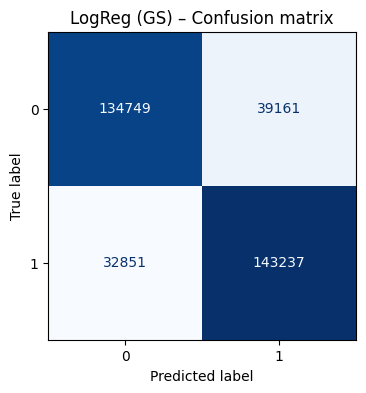

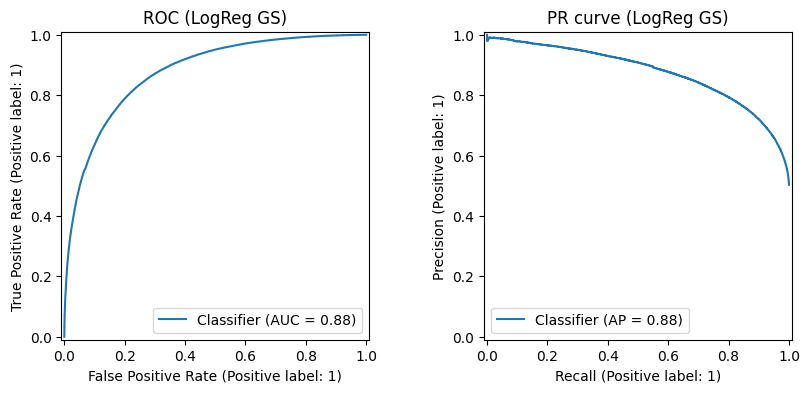

In [58]:
param_grid_lr = {
    "C": [0.25, 0.5, 1.0, 2.0],
    "penalty": ["l2"],               # "l1" тоже можно, но медленнее
    "solver": ["saga"],              # saga поддерживает l1/l2 и большие матрицы
    "class_weight": [None, "balanced"]
}
gs_lr = GridSearchCV(
    logreg, param_grid_lr, cv=3, n_jobs=-1, verbose=1,
    scoring="f1"
)
gs_lr.fit(X_train_vec, y_train)
best_lr = gs_lr.best_estimator_
print("Best LogReg:", gs_lr.best_params_)

y_pred_lr_gs = best_lr.predict(X_test_vec)
print("=== Logistic Regression (GridSearch) ===")
print_report(y_test, y_pred_lr_gs)
plot_conf_mat(y_test, y_pred_lr_gs, "LogReg (GS) – Confusion matrix")
y_score_lr_gs = best_lr.predict_proba(X_test_vec)[:,1]
plot_roc_pr(y_test, y_score_lr_gs, " (LogReg GS)")


=== LinearSVC (calibrated) ===
Accuracy: 0.7903588020502974
              precision    recall  f1-score   support

         0.0     0.8000    0.7708    0.7851    173910
         1.0     0.7815    0.8097    0.7953    176088

    accuracy                         0.7904    349998
   macro avg     0.7908    0.7902    0.7902    349998
weighted avg     0.7907    0.7904    0.7903    349998



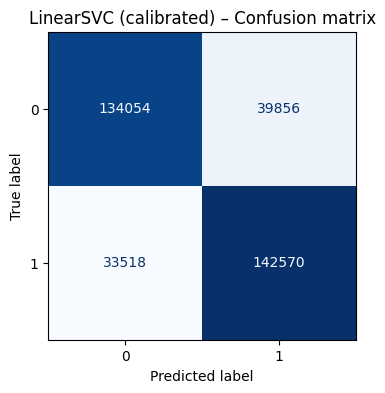

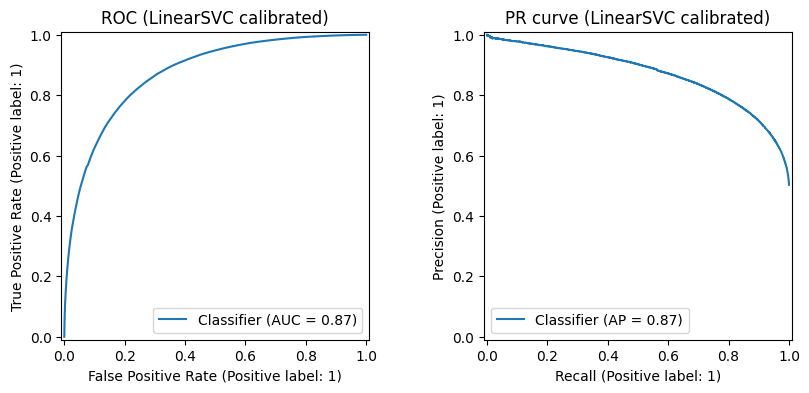

In [59]:
lsvc = LinearSVC(C=1.0, class_weight=None, random_state=RANDOM_STATE)
calibrated_lsvc = CalibratedClassifierCV(lsvc, method="sigmoid", cv=3)

calibrated_lsvc.fit(X_train_vec, y_train)
y_pred_lsvc = calibrated_lsvc.predict(X_test_vec)

print("=== LinearSVC (calibrated) ===")
print_report(y_test, y_pred_lsvc)
plot_conf_mat(y_test, y_pred_lsvc, "LinearSVC (calibrated) – Confusion matrix")

y_score_lsvc = calibrated_lsvc.predict_proba(X_test_vec)[:,1]
plot_roc_pr(y_test, y_score_lsvc, " (LinearSVC calibrated)")


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best LinearSVC: {'estimator__C': 0.5, 'estimator__class_weight': None}
=== LinearSVC (GS, calibrated) ===
Accuracy: 0.792458814050366
              precision    recall  f1-score   support

         0.0     0.8019    0.7733    0.7874    173910
         1.0     0.7838    0.8113    0.7973    176088

    accuracy                         0.7925    349998
   macro avg     0.7928    0.7923    0.7923    349998
weighted avg     0.7928    0.7925    0.7924    349998



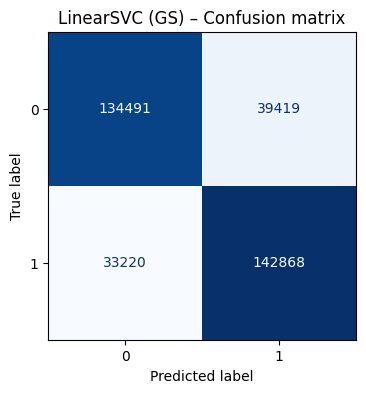

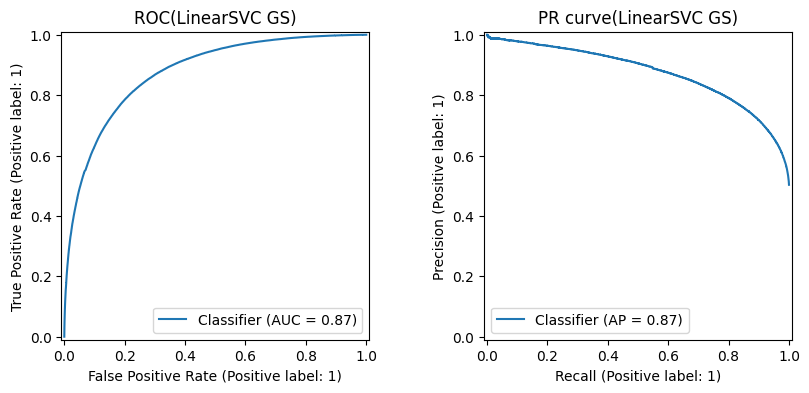

In [60]:
param_grid_lsvc = {
    "estimator__C": [0.5, 1.0, 2.0],
    "estimator__class_weight": [None, "balanced"],
}

pipe_lsvc = CalibratedClassifierCV(
    estimator=LinearSVC(random_state=RANDOM_STATE),
    method="sigmoid",
    cv=3,
)

gs_lsvc = GridSearchCV(
    pipe_lsvc,
    param_grid_lsvc,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="f1",
)

gs_lsvc.fit(X_train_vec, y_train)
best_lsvc = gs_lsvc.best_estimator_
print("Best LinearSVC:", gs_lsvc.best_params_)

y_pred_lsvc_gs = best_lsvc.predict(X_test_vec)
print("=== LinearSVC (GS, calibrated) ===")
print_report(y_test, y_pred_lsvc_gs)

y_score_lsvc_gs = best_lsvc.predict_proba(X_test_vec)[:, 1]
plot_conf_mat(y_test, y_pred_lsvc_gs, "LinearSVC (GS) – Confusion matrix")
plot_roc_pr(y_test, y_score_lsvc_gs, "(LinearSVC GS)")


In [61]:
def collect_metrics_row(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    return {"model": name, "accuracy": acc, "precision_w": prec, "recall_w": rec, "f1_w": f1}

rows = []
rows.append(collect_metrics_row("LogReg (baseline)", y_test, y_pred_lr))
rows.append(collect_metrics_row("LogReg (GS)", y_test, y_pred_lr_gs))
rows.append(collect_metrics_row("LinearSVC (calibrated)", y_test, y_pred_lsvc))
#rows.append(collect_metrics_row("LinearSVC (GS, calibrated)", y_test, y_pred_lsvc_gs))
rows.append(collect_metrics_row("MultinomialNB", y_test, y_pred_nb))

results_df = pd.DataFrame(rows).sort_values("f1_w", ascending=False).reset_index(drop=True)
results_df


,model,accuracy,precision_w,recall_w,f1_w
0,LogReg (baseline),0.794250,0.794587,0.794250,0.794160
1,LogReg (GS),0.794250,0.794587,0.794250,0.794160
2,LinearSVC (calibrated),0.790359,0.790693,0.790359,0.790266
3,MultinomialNB,0.767262,0.767323,0.767262,0.767261


In [ ]:
def top_terms_linear(clf, top_k=20, title="Top terms"):
    """
    clf: либо LogisticRegression, либо LinearSVC
         (в том числе обёрнутый в CalibratedClassifierCV).
    Выводит top_k наиболее «позитивных» и «негативных» признаков.
    """
    # 1) Простой случай: у модели прямо есть coef_ (LogReg, «голый» LinearSVC)
    if hasattr(clf, "coef_"):
        coefs = clf.coef_.ravel()

    # 2) Случай CalibratedClassifierCV — смотрим внутрь calibrated_classifiers_
    elif hasattr(clf, "calibrated_classifiers_"):
        # берём первую калиброванную модель
        cc = clf.calibrated_classifiers_[0]

        # в разных версиях sklearn поле может называться
        # estimator / base_estimator / classifier — проверяем по очереди
        base = getattr(cc, "estimator", None)
        if base is None:
            base = getattr(cc, "base_estimator", None)
        if base is None:
            base = getattr(cc, "classifier", None)

        if base is None or not hasattr(base, "coef_"):
            raise AttributeError("Не удалось найти coef_ у базового классификатора внутри CalibratedClassifierCV")

        coefs = base.coef_.ravel()

    else:
        raise AttributeError("Модель не линейная или структура неизвестна (нет coef_)")

    # индексы top-k позитивных и негативных признаков
    top_pos_idx = np.argsort(coefs)[-top_k:][::-1]
    top_neg_idx = np.argsort(coefs)[:top_k]

    print(title + " – positive:")
    print(" ".join(feature_names[top_pos_idx]))
    print()
    print(title + " – negative:")
    print(" ".join(feature_names[top_neg_idx]))
    print()


print("=== Important terms: LogReg (GS) ===")
top_terms_linear(best_lr, top_k=25, title="LogReg")

print("\n=== Important terms: LinearSVC (GS) ===")
top_terms_linear(best_lsvc, top_k=25, title="LinearSVC")


In [ ]:
os.makedirs("artifacts", exist_ok=True)
joblib.dump(vec, "artifacts/tfidf_vectorizer.joblib")
joblib.dump(best_lr, "artifacts/logreg_best.joblib")
joblib.dump(best_lsvc, "artifacts/linear_svc_calibrated_best.joblib")
print("Saved to /artifacts")


## Использование обученной модели


In [ ]:
import joblib
import numpy as np
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨ «»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [ ]:
# Загружаем обученный TF-IDF-векторизатор и лучшую модель логистической регрессии
tfidf = joblib.load("artifacts/tfidf_vectorizer.joblib")
best_model = joblib.load("artifacts/logreg_best.joblib")

print("Модель и TF-IDF успешно загружены.")


In [ ]:
# Настройки препроцессинга
stop_words = stopwords.words("english")
ps = PorterStemmer()

def preprocess_text(text: str) -> str:
    """
    Полный препроцессинг:
    - токенизация
    - удаление стоп-слов
    - стемминг
    Возвращает очищенную строку.
    """
    # удаляем стоп-слова
    tokens = [w for w in tokenize(text) if w.lower() not in stop_words]
    # стемминг
    tokens = [ps.stem(w) for w in tokens]
    return " ".join(tokens)


In [ ]:
def predict_sentiment(text: str):
    """
    Делает предсказание тональности для одного текста.
    Возвращает (prob, label), где:
    - prob  — вероятность положительного класса
    - label — 1 (positive) или 0 (negative)
    """
    # препроцессинг
    text_clean = preprocess_text(text)
    
    # векторизация
    X_vec = tfidf.transform([text_clean])
    
    # вероятность класса 1 (положительный)
    prob_pos = best_model.predict_proba(X_vec)[0, 1]
    
    # метка
    label = int(prob_pos >= 0.5)
    return prob_pos, label

def predict_label_text(text: str) -> str:
    """Удобный враппер — сразу 'positive'/'negative'."""
    prob, label = predict_sentiment(text)
    return f"{'positive' if label == 1 else 'negative'} (p={prob:.3f})"


In [ ]:
import joblib
import os

os.makedirs("artifacts", exist_ok=True)

joblib.dump(vec, "artifacts/tfidf_vectorizer.joblib")        # один раз
joblib.dump(best_lr, "artifacts/logreg_best.joblib")         # LogReg
joblib.dump(best_lsvc, "artifacts/linear_svc_best.joblib")   # LinearSVC
joblib.dump(best_mnb, "artifacts/mnb_best.joblib")           # MNB

print("Все модели сохранены в папку artifacts/")

